In [37]:
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import math # to help with data reshaping of the data

import numpy as np
import torch
#import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
import tqdm
import matplotlib.pyplot as plt
import logging

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pandas: 1.4.1
numpy: 1.21.5


In [2]:
df=pd.read_csv('weatherAUS.csv', encoding='utf-8')

# Drop records where target MinTemp=NaN or MaxTemp=NaN
df=df[pd.isnull(df['MinTemp'])==False]
df=df[pd.isnull(df['MaxTemp'])==False]

df['MedTemp']=df[['MinTemp', 'MaxTemp']].median(axis=1)

df2 = df.loc[df.Location=='Canberra'].loc[:, ['Date', 'MedTemp']]
df2.head()

,Date,MedTemp
45587,2007-11-01,16.15
45588,2007-11-02,20.45
45589,2007-11-03,18.55
45590,2007-11-04,14.40
45591,2007-11-05,11.85


In [3]:
def prep_data(datain, time_step):
    # 1. y-array  
    # First, create an array with indices for y elements based on the chosen time_step
    y_indices = np.arange(start=time_step, stop=len(datain), step=time_step)
    # Create y array based on the above indices 
    y_tmp = datain[y_indices]
    
    # 2. X-array  
    # We want to have the same number of rows for X as we do for y
    rows_X = len(y_tmp)
    # Since the last element in y_tmp may not be the last element of the datain, 
    # let's ensure that X array stops with the last y
    X_tmp = datain[range(time_step*rows_X)]
    # Now take this array and reshape it into the desired shape
    X_tmp = np.reshape(X_tmp, (rows_X, time_step, 1))
    return X_tmp, y_tmp

datain = np.array(df2.MedTemp)
X, Y = prep_data(datain, 7)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [4]:
X_train.shape
Y_train.shape
X_test.shape

(391, 7, 1)

(391,)

(98, 7, 1)

In [39]:
class MockupModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, seq_len):
        super().__init__()

        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.input_size = input_size

        self.model = nn.ModuleDict({
            'lstm': nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True),
            'linear': nn.Linear(in_features=hidden_size*seq_len, out_features=output_size)})  # is this correct?l

    def forward(self, input):
        # From [batches, seqs, seq len, features]
        # to [seq len, batch data, features]
        logging.debug(f'input: {input.shape}')
        input = input.reshape(-1, self.seq_len, self.input_size)
        logging.debug(f'input trans: {input.shape}')

       
        # Data is fed to the LSTM
        out, (h_n, c_n) = self.model['lstm'](input)
        logging.debug(f'h_n: {h_n.shape}; c_n: {c_n.shape}')
        logging.debug(f'lstm out: {out.shape}')


        # in_bs = input.shape[1]
        out = out.reshape(-1, self.seq_len*self.hidden_size)
        logging.debug(f'linear in: {out.shape}')
        out = self.model['linear'](out)
        logging.debug(f'linear out: {out.shape}')
        return out


In [26]:
asdf.model['linear']

Linear(in_features=70, out_features=1, bias=True)

In [41]:
logging.basicConfig(level=logging.DEBUG)
asdf = MockupModel(input_size=1, hidden_size=10, num_layers=1, output_size=1, seq_len=7)
out = asdf(torch.tensor(X_train[:15]).float())
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO)
asdf = MockupModel(input_size=1, hidden_size=10, num_layers=2, output_size=1, seq_len=7)
out = asdf(torch.tensor(X_train[:15]).float())

DEBUG:root:input: torch.Size([15, 7, 1])
DEBUG:root:input trans: torch.Size([15, 7, 1])
DEBUG:root:h_n: torch.Size([1, 15, 10]); c_n: torch.Size([1, 15, 10])
DEBUG:root:lstm out: torch.Size([15, 7, 10])
DEBUG:root:linear in: torch.Size([15, 70])
DEBUG:root:linear out: torch.Size([15, 1])


In [66]:
from sklearn.utils import shuffle

In [64]:
[1,2,3][1:10]

[2, 3]

391

100%|██████████| 300/300 [00:02<00:00, 100.00it/s]


[32.098350524902344, 31.896459579467773, 31.68134117126465, 31.456096649169922]


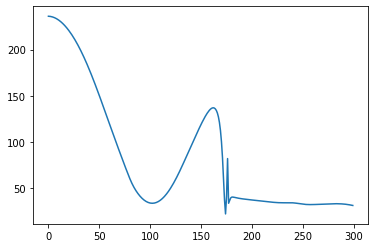

In [78]:
criterion = nn.MSELoss()
learning_rate=0.00001
losses = []

rnn = MockupModel(input_size=1, hidden_size=10, num_layers=1, output_size=1, seq_len=7)

n_iter = 300
bs = 30


for i in tqdm.tqdm(range(n_iter)):
    x, y = shuffle(X_train, Y_train)
        # epoch_losses = []
        # for b in np.arange(len(y), bs):
        #     x_b, y_b = x[b:b+bs], y[b:b+bs]
        #     output = rnn(torch.tensor(x_b).float())

        #     loss = criterion(output.reshape(-1), torch.tensor(y_b).float())
        #     loss.backward()
        #     for p in rnn.parameters():
        #             _ = p.data.add_(p.grad.data, alpha=-learning_rate)

        #     epoch_losses.append(loss.item())
        # losses.append(np.mean(epoch_losses))
    output = rnn(torch.tensor(X_train).float())
    loss = criterion(output.reshape(-1), torch.tensor(Y_train).float())
    loss.backward()
    for p in rnn.parameters():
        _ = p.data.add_(p.grad.data, alpha=-learning_rate)
    losses.append(loss.item())

plt.plot(losses)
print(losses[-4:])

In [76]:
y.shape

(391,)

In [50]:
xin = df2.MedTemp[:7].array
def predict(xin):
    # hidden = rnn.initHidden()
    out = rnn(torch.tensor(xin).float().reshape(1, -1))
    yout = out.detach().numpy()
    return yout




<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

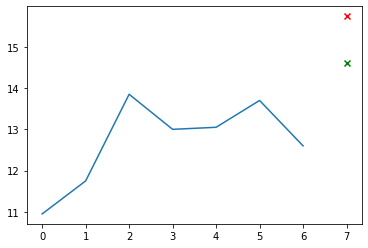

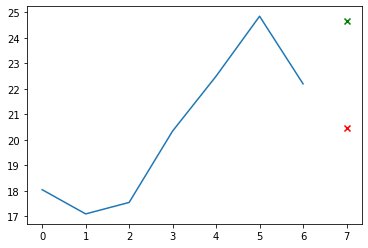

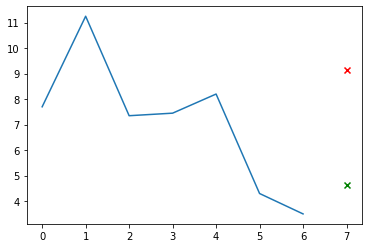

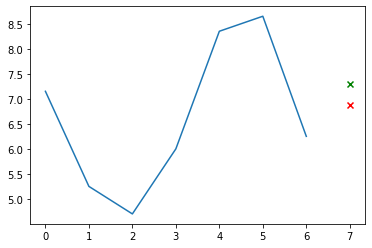

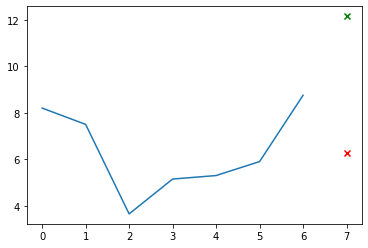

In [51]:
def plot(xin, ypred, ytrue):
    plt.plot(xin)
    plt.scatter(len(xin), ypred, color='r', marker='x')
    plt.scatter(len(xin), ytrue, color='g', marker='x')


for i in range(10, 15):
    xin = X_test[i]
    ypred = predict(xin)
    ytrue = Y_test[i]
    plt.figure()
    plot(xin, ypred, ytrue)


In [50]:
xin

<PandasArray>
[             16.15,              20.45, 18.549999999999997,
               14.4, 11.850000000000001, 11.549999999999999,
 12.149999999999999]
Length: 7, dtype: float64

In [ ]:
3